In [1]:
#libraries
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import *

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import load_img, img_to_array

physical_devices = tensorflow.config.list_physical_devices("GPU")
tensorflow.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [3]:
train_dataset  = train_datagen.flow_from_directory(directory = 'OASISDataset/OASISDataset',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)

Found 69151 images belonging to 4 classes.


In [4]:
valid_dataset = valid_datagen.flow_from_directory(directory = 'OASISDataset/OASISDataset',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)

Found 17286 images belonging to 4 classes.


In [5]:
# Model Initialization

base_model = MobileNetV2(input_shape=(224,224,3), 
                         include_top=False,
                         weights="imagenet")

In [6]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [7]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(512,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))


In [8]:
# Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 dropout (Dropout)           (None, 7, 7, 1280)        0         
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 batch_normalization (BatchN  (None, 62720)            250880    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2048)              128452608 
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8

In [9]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy',
              metrics=['accuracy', tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

In [10]:
# Defining Callbacks

filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [11]:

model_history = model.fit(train_dataset,
                          validation_data=valid_dataset,
                          epochs=20, 
                          callbacks=callback_list,
                          verbose=1)

Epoch 1/20
541/541 [==============================] - ETA: 0s - loss: 0.5139 - accuracy: 0.8105 - auc: 0.9553
Epoch 1: val_auc improved from -inf to 0.91618, saving model to .\best_weights.hdf5
541/541 [==============================] - 191s 346ms/step - loss: 0.5139 - accuracy: 0.8105 - auc: 0.9553 - val_loss: 0.7918 - val_accuracy: 0.7434 - val_auc: 0.9162
Epoch 2/20
541/541 [==============================] - ETA: 0s - loss: 0.1338 - accuracy: 0.9534 - auc: 0.9964
Epoch 2: val_auc did not improve from 0.91618
541/541 [==============================] - 86s 159ms/step - loss: 0.1338 - accuracy: 0.9534 - auc: 0.9964 - val_loss: 0.9723 - val_accuracy: 0.7465 - val_auc: 0.9128
Epoch 3/20
541/541 [==============================] - ETA: 0s - loss: 0.0642 - accuracy: 0.9783 - auc: 0.9990
Epoch 3: val_auc did not improve from 0.91618
541/541 [==============================] - 85s 158ms/step - loss: 0.0642 - accuracy: 0.9783 - auc: 0.9990 - val_loss: 1.0959 - val_accuracy: 0.7569 - val_auc: 0.

In [14]:

# Test Data 
test_dataset = test_datagen.flow_from_directory(directory='OASISDataset/OASISDataset',
                                                target_size=(224, 224),
                                                class_mode='categorical',
                                                batch_size=128)
# Evaluating Loss and AUC
evaluation_results = model.evaluate(test_dataset)
print(f'Test Loss: {evaluation_results[0]}, Test Accuracy: {evaluation_results[1]}, Test AUC: {evaluation_results[2]}')


Found 86437 images belonging to 4 classes.
676/676 [==============================] - 78s 114ms/step - loss: 0.3160 - accuracy: 0.9529 - auc: 0.9828
Test Loss: 0.3159942626953125, Test Accuracy: 0.9528558254241943, Test AUC: 0.9827597141265869


Found 86437 images belonging to 4 classes.
676/676 [==============================] - 74s 109ms/step


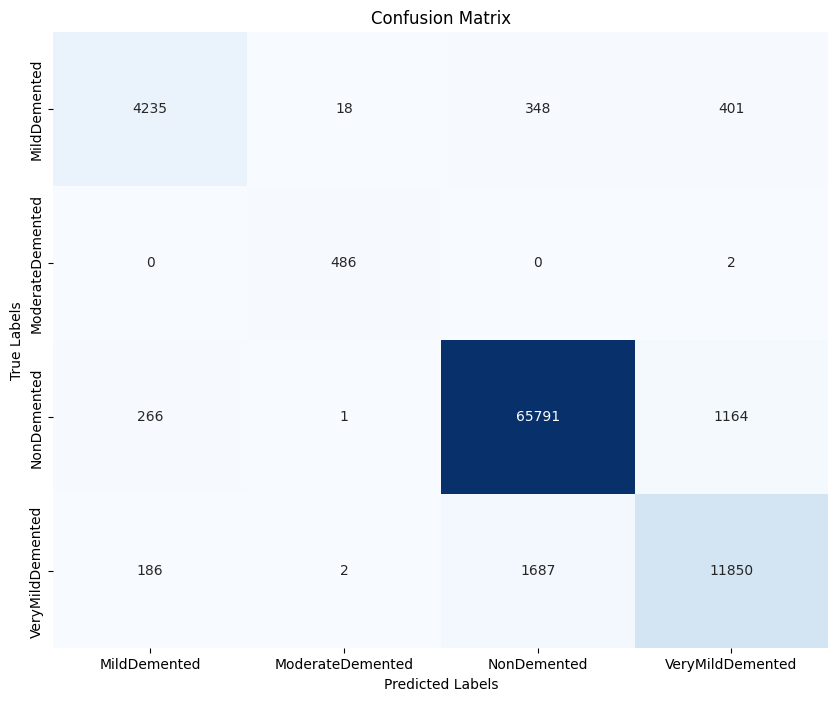

Accuracy for MildDemented: 0.85
Accuracy for ModerateDemented: 1.00
Accuracy for NonDemented: 0.98
Accuracy for VeryMildDemented: 0.86

Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.90      0.85      0.87      5002
ModerateDemented       0.96      1.00      0.98       488
     NonDemented       0.97      0.98      0.97     67222
VeryMildDemented       0.88      0.86      0.87     13725

        accuracy                           0.95     86437
       macro avg       0.93      0.92      0.92     86437
    weighted avg       0.95      0.95      0.95     86437



In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

# Custom class names
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']  # Update with your actual class names

# Test Data 
test_dataset = test_datagen.flow_from_directory(directory='OASISDataset/OASISDataset',
                                                target_size=(224, 224),
                                                class_mode='categorical',
                                                batch_size=128,
                                                shuffle=False)  # Ensure predictions match true labels

# Get predictions from the model
predictions = model.predict(test_dataset)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_labels = test_dataset.classes

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Plot confusion matrix with custom class names
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate accuracy for each class
class_accuracy = {}
for i, class_name in enumerate(class_names):
    true_positives = cm[i, i]
    total_samples = np.sum(cm[i, :])
    class_accuracy[class_name] = true_positives / total_samples

# Print accuracy for each class
for class_name, acc in class_accuracy.items():
    print(f'Accuracy for {class_name}: {acc:.2f}')

# Classification Report
report = classification_report(true_labels, predicted_classes, target_names=class_names)
print("\nClassification Report:")
print(report)


In [16]:
model.save('TrainedMObilenetv2.keras')
model.save_weights('TrainedMobilenetv2Weights.h5')